# TODO
* Leitfaden zur Reproduzierung der Slides und Code für
    * Just Code
        Remote: CPU/GPU: Colab
        Remote: CPU only: Blender
        Local: Clone Repo and follow instructions
    * Code with slides:
        Remote: CPU only: Blender
        Local CPU/GPU: Clone repo and follow instructions
* Better CSS for IFIS style slides
    * Have H1 headings on top of screen
    * Have horizontal lines above and below H1 headings
    * Have Content starting at fixed height
    * Add a footer with author name and Institute



# AI Camp 2020 Kickoff
## Welcome!

# Agenda
* Ziele
* Organisatorisches
    * Coding usw

# Ziele
blabla

# Organisatorisches
 - Lectures & Examples in Python
     - Frameworks: Tensorflow, Pytorch, sklearn, etc.
 - Slides & Code in <a href="https://jupyter.org/">Jupyter Notebooks</a>
 - Everything is located in Niklas' <a href="https://github.com/nikrruun/jupyter-notebooks/tree/aicamp2020">GitHub Repo</a>
     - Branch "aicamp2020"

# Why Jupyter Notebooks?
We want to present math and code for sophisticated AI models
> We have PowerPoint for this!

But wouldn't it be nice, if we also could
- Actually run the code during presentation
- Interact with it and observe changes
- Easily share it and ship to remote hardware
   


# You're in a simulation
This presentation is a Jupyter Notebook too:

In [14]:
import time
for i in range(10):
    print(f"2^{i} =", 2**i)
    time.sleep(1)

2^0 = 1
2^1 = 2
2^2 = 4
2^3 = 8
2^4 = 16
2^5 = 32
2^6 = 64
2^7 = 128
2^8 = 256
2^9 = 512


And it's also interactive!

# Features 
* Inline Latex support: $e^yx_k\sum_{i=1}{2^{-i}}$
* Text narratives via markdown (essentially a readme.md)
* Usually, a notebook is a list of sequential code or text cells
    - But, with some effort it automatically translates into a slideshow
* Run a copy on <a href="https://colab.research.google.com">Google Colab</a> in < 1 minute
    

# Google Colab walkthrough
1. Open the link <a href="https://colab.research.google.com">Google Colab</a>
2. Sign up & in, and open a new notebook
3. Go to tab "GitHub" and search for user "nikrruun". Choose as shown below:
<img src="img/slides/colab_github_menu.png">

# Google Colab (2)
4. Click on "<i>kickoff_presentation.ipynb</i>"
    - Generally, Google Colab filters out all available notebooks from a given repository

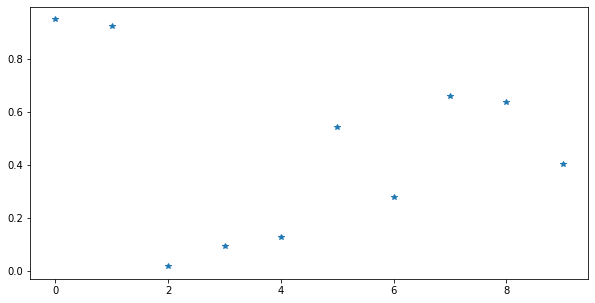

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
a = plt.plot(np.random.rand(10), "*")

In [1]:
import numpy as np
from tensorflow.keras.layers import (
    Dense, Input, Dropout    
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow import keras

import gym

In [2]:
def episode(env, model, render=False, max_steps=None):
    states = []
    action_probs = []
    est_rewards = []
    rewards = []

    state = env.reset()
    i = 0
    while i < (j := max_steps if max_steps is not None else np.inf):
        if render: 
            env.render()
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        states.append(state)

        a_p, e_w = model(state)
        action = np.random.choice(env.action_space.n, p=np.squeeze(a_p))
        state, reward, done, info = env.step(action)

        action_probs.append(a_p[0, action])
        est_rewards.append(e_w[0,0])
        rewards.append(reward)

        i += 1
        if done:
            break
    env.close()
    return states, rewards, action_probs, est_rewards

In [5]:
epochs = 1000
gamma = 0.9
train_max_steps = 200
validation_every = 5
validation_episodes = 5
validation_max_steps = 200
env = gym.make('CartPole-v0').unwrapped
#env = gym.make('MountainCar-v0').unwrapped

critic_loss_func = keras.losses.Huber()

input_layer = Input(env.observation_space.shape)
l = Dense(128, "relu")(input_layer)
l = Dense(64, "relu")(l)
actor = Dense(env.action_space.n, "softmax", name="actor")(l)
critic = Dense(1, name="critic")(l)
model = Model(input_layer, [actor, critic])

model.summary()
opt = keras.optimizers.Adam(lr=0.01)
reward_history = []

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          640         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           8256        dense_2[0][0]                    
__________________________________________________________________________________________________
actor (Dense)                   (None, 2)            130         dense_3[0][0]                    
____________________________________________________________________________________________

In [6]:
for epoch in range(epochs):

    with tf.GradientTape() as tape:
        states, rewards, action_probs, est_rewards = episode(env, model, False, train_max_steps)
        reward_history.append(sum(rewards))

        returns = []
        discounted_sum = 0
        for r in rewards[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = np.array(returns)
        returns = (returns - returns.mean()) / returns.std()

        critic_labels = tf.convert_to_tensor(returns, "float32")

        # critic_loss = critic_loss_func(est_rewards, critic_labels)
        cl = []
        for f,g in zip(est_rewards, critic_labels):
            cl.append(critic_loss_func(tf.expand_dims(f,0), tf.expand_dims(g,0)))
        critic_loss = sum(cl)

        al = -tf.math.log(action_probs) * (critic_labels - est_rewards)
        actor_loss = sum(al)
        loss = actor_loss + critic_loss

        gradients = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(gradients, model.trainable_weights))

    if epoch % validation_every == 0:
        val_rewards = []
        for val_e in range(validation_episodes):
            states, rewards, action_probs, est_rewards = episode(env, model, False, validation_max_steps)
            val_rewards.append(sum(rewards))
        val_rewards = np.array(val_rewards)
        print(f"Epoch {epoch}/{epochs}",np.mean(reward_history),  val_rewards.min(), val_rewards.max(), val_rewards.mean())
        reward_history.clear()
        #episode(env, model, True, validation_max_steps)
        pass

Epoch 0/1000 0 10.0 12.0 30.0 20.8
Epoch 5/1000 5 13.0 10.0 39.0 19.6
Epoch 10/1000 10 17.6 9.0 31.0 19.4
Epoch 15/1000 15 14.0 10.0 20.0 15.4
Epoch 20/1000 20 12.2 10.0 15.0 12.4
Epoch 25/1000 25 14.4 9.0 13.0 11.0
Epoch 30/1000 30 11.4 11.0 16.0 13.8
Epoch 35/1000 35 15.8 10.0 13.0 12.0
Epoch 40/1000 40 14.6 10.0 16.0 13.0
Epoch 45/1000 45 15.8 17.0 31.0 23.2
Epoch 50/1000 50 31.2 12.0 23.0 15.6
Epoch 55/1000 55 19.4 12.0 58.0 30.6
Epoch 60/1000 60 18.6 14.0 26.0 20.2
Epoch 65/1000 65 41.6 13.0 35.0 20.2
Epoch 70/1000 70 40.0 12.0 18.0 14.4
Epoch 75/1000 75 15.6 16.0 39.0 22.6
Epoch 80/1000 80 19.0 8.0 16.0 11.8
Epoch 85/1000 85 13.8 13.0 33.0 21.0
Epoch 90/1000 90 21.6 15.0 35.0 22.6
Epoch 95/1000 95 34.8 13.0 71.0 34.6
Epoch 100/1000 100 55.2 13.0 43.0 23.0
Epoch 105/1000 105 26.2 25.0 52.0 35.8
Epoch 110/1000 110 21.6 14.0 54.0 30.6
Epoch 115/1000 115 40.6 15.0 70.0 40.4
Epoch 120/1000 120 28.0 23.0 64.0 45.0
Epoch 125/1000 125 26.0 12.0 20.0 15.2
Epoch 130/1000 130 12.4 9.0 28.0 

KeyboardInterrupt: 